# Setup

**Imports**

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from loadmydata.load_human_locomotion import (
    load_human_locomotion_dataset,
    get_code_list,
)

**Utility functions**

In [237]:
def fig_ax(figsize=(15, 5), subplot=1):
    fig, axs = plt.subplots(subplot, figsize=figsize)
    if subplot > 1:
        for i in range(subplot):
            axs[i].autoscale(enable=True, axis='x', tight=True)
    else:
        axs.autoscale(enable=True, axis='x', tight=True)
    return fig, axs

# Spectral feature

## Question 6

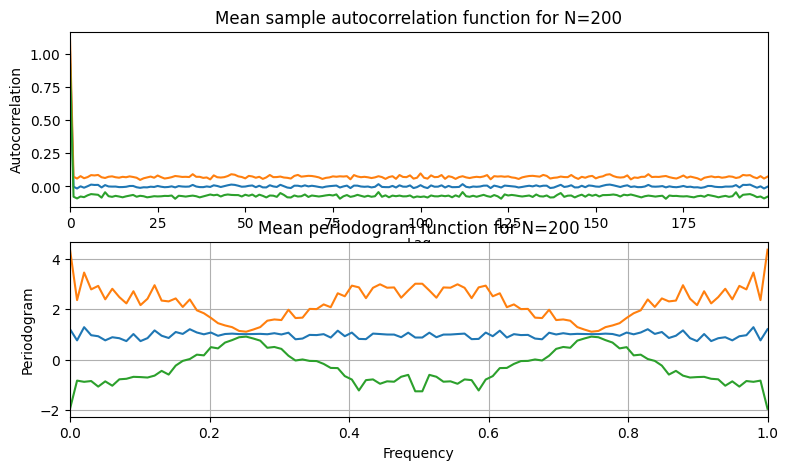

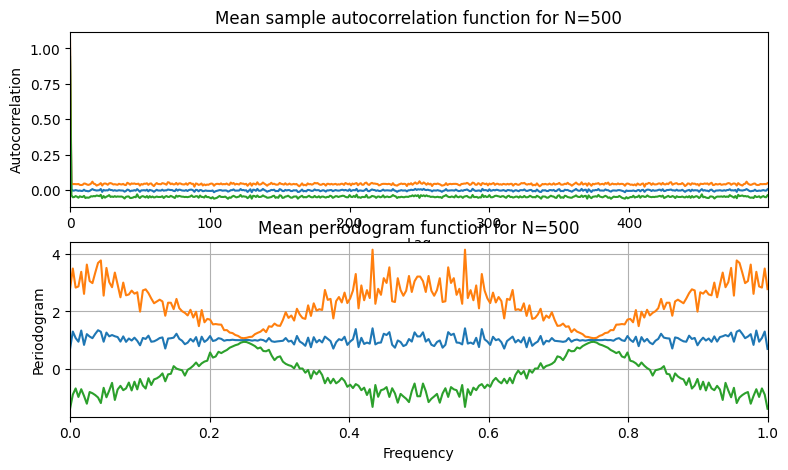

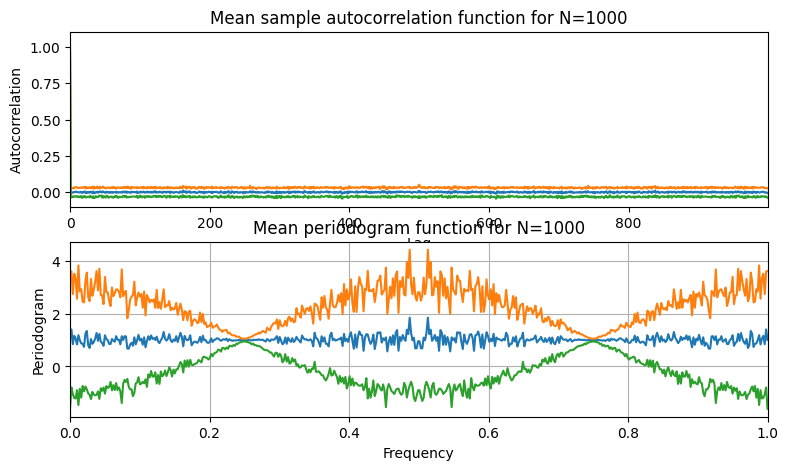

In [313]:
from functools import partial


def gaussian_whitenoise(sampling_freq=1, n_freqs=200, n_samples=100, std=1):
    """
    Generate Gaussian white noise signals.
    :param sampling_freq: Sampling frequency.
    :param n_freqs: sampling frequencies = k * sampling_freq / n_freqs
    :param n_samples: number of realizations
    :param std: standard deviation of the Gaussian noise
    :return: (gaussian, freqs)
    """
    gaussian = std * np.random.randn(n_samples, n_freqs)  # shape (n_trials, n_freqs)
    freqs = np.linspace(0, sampling_freq, n_freqs // 2)
    return gaussian, freqs


def sample_autocorrelation(signals, lags):
    """
    Sample autocorrelation function
    :param lag: lag
    :return: autocorrelation
    """
    sample_autocorrelations = np.array([np.mean(np.roll(signals, lag, axis=-1) * signals, axis=-1) for lag in lags]).T
    return sample_autocorrelations


def periodogram(sample_autocorrelations, freqs, sampling_freq=1):
    """
    Periodogram computed using the sample autocorrelation function
    :param sample_autocorrelations: sample autocorrelation function
    :param freq: input freq. of the periodogram
    :param sampling_freq: sampling frequency
    :return: periodogram evaluated at freq.
    """
    vec = 2 * np.array(
        [
            np.array(
                [np.cos(2 * np.pi * freq * tau / sampling_freq) for tau in range(sample_autocorrelations.shape[-1])])
            for freq in freqs]
    )
    vec[:, 0] = 1
    vec = vec.T
    module_Jfk = sample_autocorrelations @ vec
    return module_Jfk


Ns = [200, 500, 1000]
for N in Ns:
    fig, axs = fig_ax(figsize=(9, 5), subplot=2)
    gaussian_whitenoises, freqs = gaussian_whitenoise(n_freqs=N)
    lags = np.arange(0, N)
    sample_autocorrelations = sample_autocorrelation(gaussian_whitenoises, lags)
    mean_sample_autocorrelations = np.mean(sample_autocorrelations, axis=0)
    std_sample_autocorrelations = np.std(sample_autocorrelations, axis=0)

    periodograms = periodogram(sample_autocorrelations, freqs=freqs)
    mean_periodogram = np.mean(periodograms, axis=0)
    std_periodogram = np.std(periodograms, axis=0)

    axs[0].plot(lags, mean_sample_autocorrelations)
    axs[0].plot(lags, mean_sample_autocorrelations + std_sample_autocorrelations)
    axs[0].plot(lags, mean_sample_autocorrelations - std_sample_autocorrelations)
    axs[0].set_title(f"Mean sample autocorrelation function for N={N}")
    axs[0].set_xlabel("Lag")
    axs[0].set_ylabel("Autocorrelation")

    axs[1].set_title(f"Mean periodogram function for N={N}")
    axs[1].set_xlabel("Frequency")
    axs[1].set_ylabel("Periodogram")
    axs[1].plot(freqs, mean_periodogram)
    axs[1].plot(freqs, mean_periodogram + std_periodogram)
    axs[1].plot(freqs, mean_periodogram - std_periodogram)
    axs[1].grid()

## Question 9

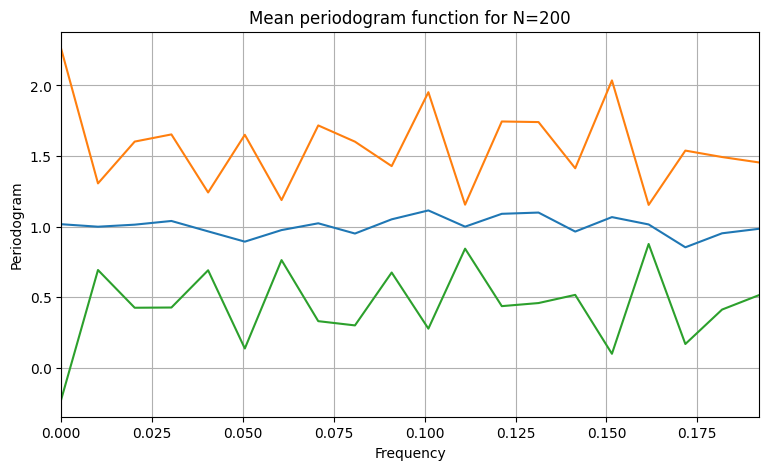

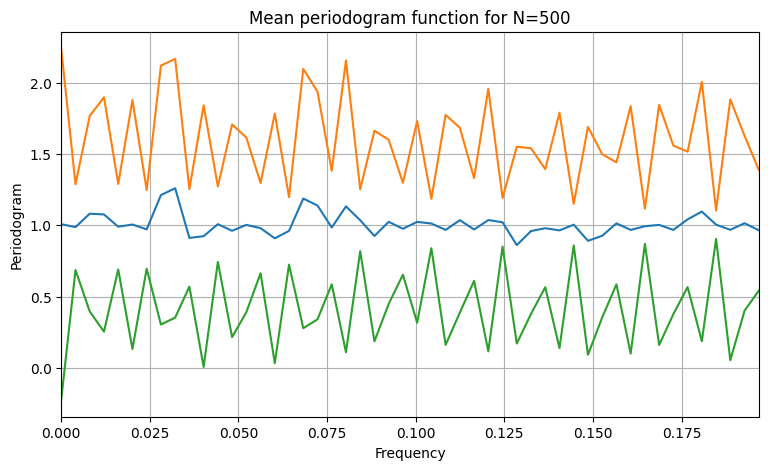

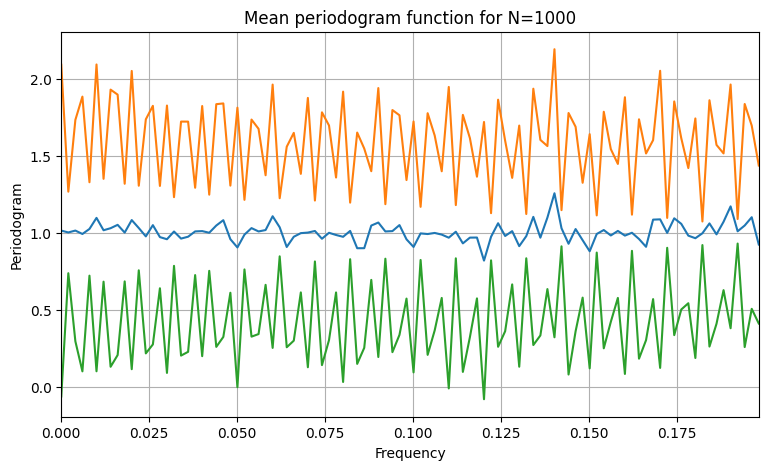

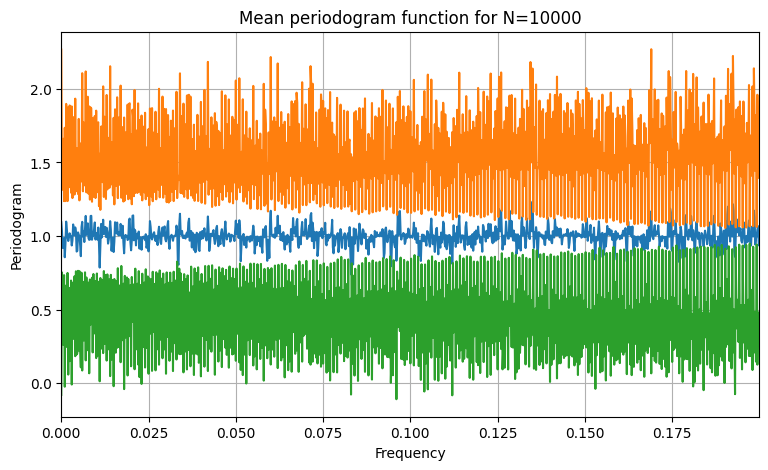

In [369]:
Ns = [200, 500, 1000, 10000]
section = 5
for N in Ns:
    fig, axs = fig_ax(figsize=(9, 5))
    gaussian_whitenoises, freqs = gaussian_whitenoise(n_freqs=N)
    gaussian_whitenoises = gaussian_whitenoises.reshape(-1, section, N // section)
    lags = np.arange(0, N // section)
    freqs = freqs[:N // 2 // section]
    sample_autocorrelations = sample_autocorrelation(gaussian_whitenoises, lags)
    periodograms = np.mean(periodogram(sample_autocorrelations, freqs=freqs), axis=0)
    mean_periodogram = np.mean(periodograms, axis=0)
    std_periodogram = np.std(periodograms, axis=0)

    axs.set_title(f"Barlett's estimate of the periodogram function for N={N}")
    axs.set_xlabel("Frequency")
    axs.set_ylabel("Periodogram")
    axs.plot(freqs, mean_periodogram)
    axs.plot(freqs, mean_periodogram + std_periodogram)
    axs.plot(freqs, mean_periodogram - std_periodogram)
    axs.grid()

# Dynamic time warping (DTW)

## Data

This data set consists of signals collected with inertial measurement units (accelerometer+gyroscope), from 230 subjects undergoing a fixed protocol:
- standing still,
- walking 10 m,
- turning around,
- walking back,
- stopping.

In this assignment, we only consider the vertical acceleration of the left foot and all signals are truncated to 20 seconds (as a result, they all have same length). Signals are sampled at 100 Hz.

The measured population is composed of healthy subjects as well as patients with neurological or orthopedic disorders.

The start and end time stamps of thousands of footsteps are available.

The data are part of a larger data set described in [1].

[1] Truong, C., Barrois-Müller, R., Moreau, T., Provost, C., Vienne-Jumeau, A., Moreau, A., Vidal, P.-P., Vayatis, N., Buffat, S., Yelnik, A., Ricard, D., & Oudre, L. (2019). A data set for the study of human locomotion with inertial measurements units. Image Processing On Line (IPOL), 9.

**The task** is to classify footsteps in healthy/non-healthy.

The following cell defines the training set `(X_train, y_train)` and testing set `(X_test, y_test)`.

In [ ]:
subset_indexes_train = [95, 619, 441, 149, 951, 803, 214, 34, 37, 630]
subset_indexes_test = [683, 259, 59, 387, 634]

code_list = get_code_list()

X_train = list()  # list of footstep signals
y_train = list()  # list of pathologies (the "labels")

for code in np.take(code_list, subset_indexes_train):
    single_trial = load_human_locomotion_dataset(code)
    signal = single_trial.signal.LAZ.to_numpy()  # keeping only one dimension (from the left sensor)
    steps = single_trial.left_steps
    pathology = single_trial.metadata["PathologyGroup"]
    label = 0 if pathology == "Healthy" else 1  # 0: healthy, 1: non-healthy
    for (start, end) in steps:
        X_train.append(signal[start:end])
        y_train.append(label)

X_test = list()  # list of footstep signals
y_test = list()  # list of pathologies (the "labels")

for code in np.take(code_list, subset_indexes_test):
    single_trial = load_human_locomotion_dataset(code)
    signal = single_trial.signal.LAZ.to_numpy()  # keeping only one dimension (from the left sensor)
    steps = single_trial.left_steps
    pathology = single_trial.metadata["PathologyGroup"]
    label = 0 if pathology == "Healthy" else 1  # 0: healthy, 1: non-healthy
    for (start, end) in steps:
        X_test.append(signal[start:end])
        y_test.append(label)

## Question 10

## Question 11